In [1]:
#pip uninstall matplotlib

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
%matplotlib inline

In [3]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088

# load the data set
df = pd.read_csv('input/summer-travel-gps-dbscan.csv', encoding='utf-8')
df.head()

In [4]:
# load the data set
df = pd.read_csv('input/earthquakes.csv', encoding='utf-8')
df.head()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [42]:
# represent points consistently as (lat, lon)
coords = df.as_matrix(columns=['Latitude', 'Longitude'])

# define epsilon as 15 kilometers to better define clusters, converted to radians for use by haversine
epsilon = 15 / kms_per_radian

C:\Users\EasyE\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [43]:
start_time = time.time()
db = DBSCAN(eps=epsilon, min_samples=2, algorithm='ball_tree', metric = "haversine").fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# all done, print the outcome
message = 'Clustered {:,} points down to {:,} clusters, for {:.1f}% compression in {:,.2f} seconds'
print(message.format(len(df), num_clusters, 100*(1 - float(num_clusters) / len(df)), time.time()-start_time))
print('Silhouette coefficient: {:0.03f}'.format(metrics.silhouette_score(coords, cluster_labels)))

Clustered 23,412 points down to 2,799 clusters, for 88.0% compression in 6.62 seconds
Silhouette coefficient: -0.002


In [40]:
print(cluster_labels)

[   0    1    2 ... 2723   -1  315]


In [41]:
import collections
collections.Counter(cluster_labels)

Counter({0: 3,
         1: 30,
         2: 112,
         -1: 6446,
         3: 2,
         4: 210,
         5: 171,
         6: 8,
         7: 154,
         8: 9,
         9: 57,
         10: 10,
         11: 8,
         12: 4,
         13: 3,
         14: 3,
         15: 6,
         16: 4,
         17: 8,
         18: 7,
         19: 12,
         20: 10,
         21: 2,
         22: 5,
         23: 25,
         24: 2,
         25: 40,
         26: 8,
         27: 2,
         28: 219,
         29: 4,
         30: 188,
         31: 10,
         32: 3,
         33: 4,
         34: 4,
         35: 24,
         36: 9,
         37: 11,
         38: 157,
         39: 94,
         40: 2,
         41: 2,
         42: 7,
         43: 6,
         44: 4,
         45: 8,
         46: 18,
         47: 6,
         48: 9,
         49: 12,
         50: 38,
         51: 11,
         52: 48,
         53: 2,
         54: 2,
         55: 4,
         56: 28,
         57: 2,
         58: 5,
         59: 92,

In [14]:
# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [15]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)

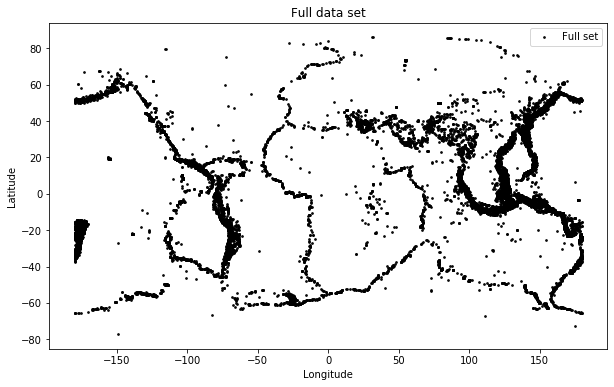

In [16]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter], ['Full set'], loc='upper right')
plt.show()

In [17]:
# unzip the list of centermost points (lat, lon) tuples into separate lat and lon lists
lats, lons = zip(*centermost_points)

# from these lats/lons create a new df of one representative point for each cluster
rep_points = pd.DataFrame({'Longitude':lons, 'Latitude':lats})
rep_points.tail()

,Longitude,Latitude
536,-55.8867,13.2000
537,82.5565,-23.9646
538,148.7233,-19.8352
539,31.6181,-1.0355
540,84.9583,37.1442


In [18]:
# pull row from original data set where lat/lon match the lat/lon of each row of representative points
# that way we get the full details like city, country, and date from the original dataframe
rs = rep_points.apply(lambda row: df[(df['Latitude']==row['Latitude']) & (df['Longitude']==row['Longitude'])].iloc[0], axis=1)
rs.to_csv('output/earthquakes1970-2014-dbscan-processed.csv', encoding='utf-8')
rs.tail()

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
536,04/20/2016,10:51:42,13.2000,-55.8867,Earthquake,28.0,1.8,NaN,5.6,MWW,...,NaN,28.0,3.577,7.3,1.04,US20005K4S,US,US,US,Reviewed
537,08/01/2016,07:42:51,-23.9646,82.5565,Earthquake,10.0,1.6,NaN,5.6,MWW,...,NaN,34.0,18.292,8.3,0.95,US1000694I,US,US,US,Reviewed
538,08/18/2016,04:30:09,-19.8352,148.7233,Earthquake,10.0,1.8,NaN,5.7,MWW,...,NaN,30.0,2.335,7.1,0.82,US10006EM9,US,US,US,Reviewed
539,09/10/2016,12:27:33,-1.0355,31.6181,Earthquake,40.0,1.9,NaN,5.9,MWW,...,NaN,21.0,5.634,8.9,0.88,US10006NKX,US,US,US,Reviewed
540,12/20/2016,10:04:39,37.1442,84.9583,Earthquake,10.0,1.7,NaN,5.6,MWW,...,NaN,15.0,7.182,7.6,0.83,US200082S5,US,US,US,Reviewed


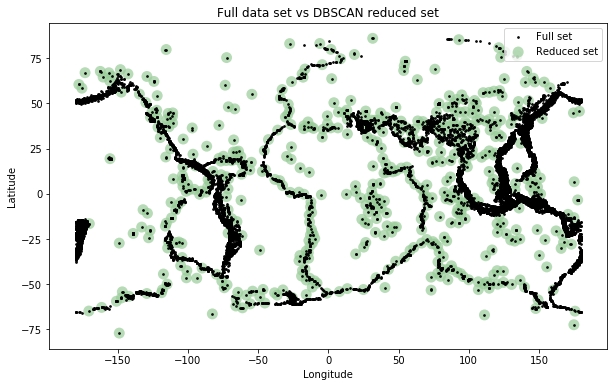

In [19]:
# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()

In [20]:
#pip install basemap

In [21]:
#C:\Users\EasyE\Anaconda3\Library\share
#conda install -c conda-forge proj4
import os

os.environ['PROJ_LIB'] = r'C:\Users\EasyE\Anaconda3\Library\share'

In [22]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

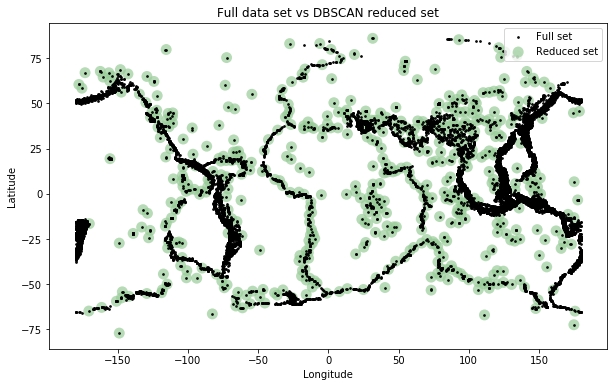

In [23]:
#fig = plt.figure(num=None, figsize=(12, 8) )
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,resolution='c')
#m.drawcoastlines()
#plt.title("Mercator Projection")

# plot the final reduced set of coordinate points vs the original full set
fig, ax = plt.subplots(figsize=[10, 6])
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,llcrnrlon=-180,urcrnrlon=180,resolution='c')
#m.drawcoastlines()
rs_scatter = ax.scatter(rs['Longitude'], rs['Latitude'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['Longitude'], df['Latitude'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')

plt.show()

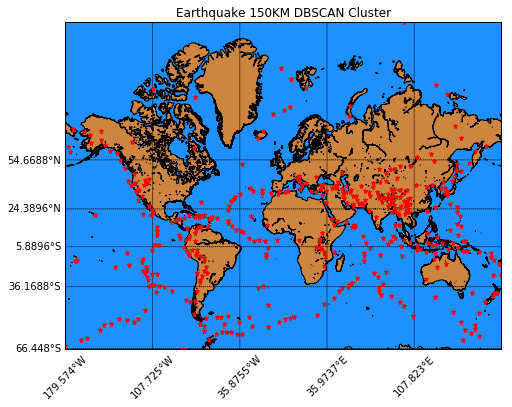

In [35]:
#!/usr/bin/python
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import csv

#appended list
lats, lons = [],[]


#44 years of earthquakes
with open('output/earthquakes1970-2014-dbscan-processed.csv') as csvfile:
    reader = csv.DictReader(csvfile,delimiter=',')
    for data in reader:
        #names.append(data['CALL'])
        lats.append(float(data['Latitude']))
        lons.append(float(data['Longitude']))
        #altitude.append(float(data['ELEV']))

# How much to zoom from coordinates (in degrees)
zoom_scale = 0

# Setup the bounding box for the zoom and bounds of the map
bbox = [np.min(lats)-zoom_scale,np.max(lats)+zoom_scale,\
        np.min(lons)-zoom_scale,np.max(lons)+zoom_scale]

plt.figure(figsize=(12,6))
# Define the projection, scale, the corners of the map, and the resolution.
m = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i')

# Draw coastlines and fill continents and water with color
m.drawcoastlines()
m.fillcontinents(color='peru',lake_color='dodgerblue')

# draw parallels, meridians, and color boundaries
m.drawparallels(np.arange(bbox[0],bbox[1],(bbox[1]-bbox[0])/5),labels=[1,0,0,0])
m.drawmeridians(np.arange(bbox[2],bbox[3],(bbox[3]-bbox[2])/5),labels=[0,0,0,1],rotation=45)
m.drawmapboundary(fill_color='dodgerblue')

# build and plot coordinates onto map
x,y = m(lons,lats)
m.plot(x,y,'r*',markersize=5)
plt.title("Earthquake 150KM DBSCAN Cluster")
plt.savefig('output/earthquake_plots.png', format='png', dpi=500)
plt.show()

#Code Example
#https://makersportal.com/blog/2018/7/20/geographic-mapping-from-a-csv-file-using-python-and-basemap